In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
plt.style.use(style='seaborn')
%matplotlib inline

In [3]:
df = pd.read_csv(r'C:\Users\ASUS\Desktop\AXISBANK.csv')

In [4]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,03-01-2000,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11,NaN,NaN,NaN
1,04-01-2000,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387280e+11,NaN,NaN,NaN
2,05-01-2000,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11,NaN,NaN,NaN
3,06-01-2000,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11,NaN,NaN,NaN
4,07-01-2000,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11,NaN,NaN,NaN


In [5]:
df = df[["Close"]].copy()

In [6]:
df.head()

,Close
0,26.70
1,26.85
2,26.30
3,25.95
4,24.80


## ADF Test to check the Stationarity

The null hypothesis of the ADF test is that the time series is non-stationary. So, if p-value < 0.05 then the time series is stationary

In [7]:
df.describe()

,Close
count,5306.000000
mean,585.893931
std,436.649765
min,22.150000
25%,230.975000
50%,519.500000
75%,877.312500
max,2023.350000


In [8]:
from statsmodels.tsa.stattools import adfuller

adf_list = adfuller(df.Close.dropna())

pvalue = adf_list[1]
print(f"pvalue: {pvalue}")

pvalue: 0.10335825050857911


Here, p-value > 0.05 that's why the time series is not stationary. We will need to use the concept of Differencing.

## Differencing

Two ways to find out the minimum number of differencing operations needed:

### Autocorrelation Function (ACF)

- Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.
- Autocorrelation measures the relationship between a variable’s current value and its past values.
- An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.
- An autocorrelation helps us identify the seasonality in our time series data.
- The x-axis of the correlogram represents the time lag and the y-axis represents the autocorrelation.
- Make sure your data doesn’t have NA values, otherwise the ACF will fail.

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

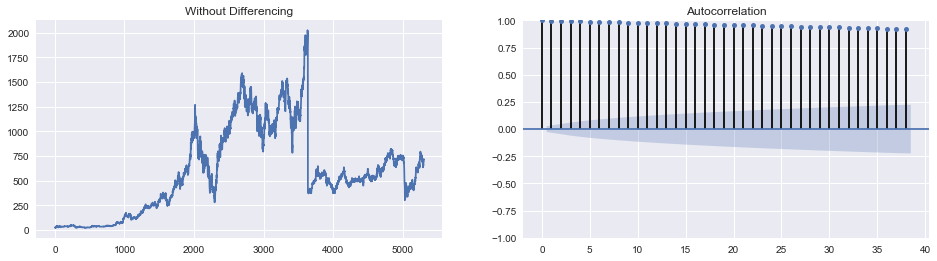

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title("Without Differencing")
plot_acf(df.Close, ax=ax2);

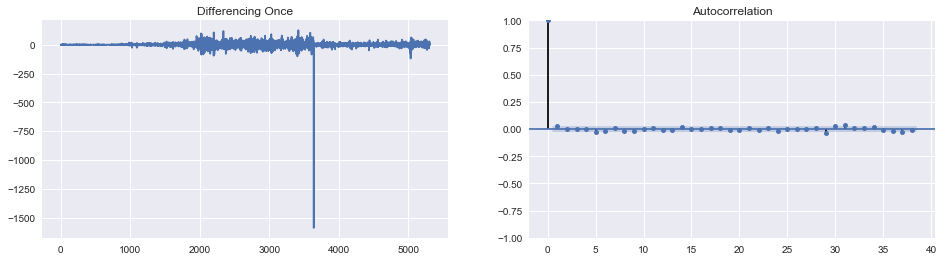

In [11]:
diff_1 = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff_1)
ax1.set_title("Differencing Once")
plot_acf(diff_1, ax=ax2);

### Using pmdarima package 

We can use the ndiffs function directly to get the minimum rounds of differencing required

In [12]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [13]:
from pmdarima.arima.utils import ndiffs

ndiffs(df.Close, test='adf')

1

##### Hence we only need to perform differencing once i.e. d = 1

## Finding out the *p* input parameter to the ARIMA model

- p refers to the Auto Regressive (AR) term.
- It tells the model number of lags to be use as predictors
- Partial Autocorrelation (PACF) plot helps in figuring out the *p*
- Partial Autocorrelation represents the correlation between the series and its lags

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

We will consider first order differencing below since we chose *d = 1*

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


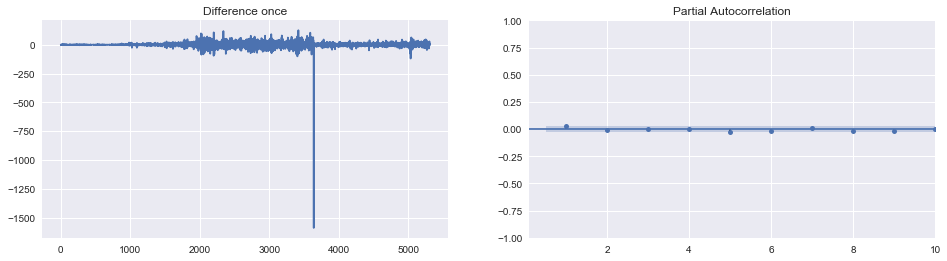

In [15]:
diff1 = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff1)
ax1.set_title("Difference once")
ax2.set_xlim(0.1,10)
ax2.set_ylim(0,0.25)
plot_pacf(diff1, ax=ax2);

The partial correlation value of 0 stands out the most hence we will choose it as out p paramerter

#### Value of parameter *p* is 0

## Figuring out the *q* parameter

- q is the number of lagged forecast errors in the prediction equation
- q is the order of the Moving Average (MA) term, it refers to the number of lagged forecast errors that should go into the ARIMA model
- ACF plot does give us the number of MA terms

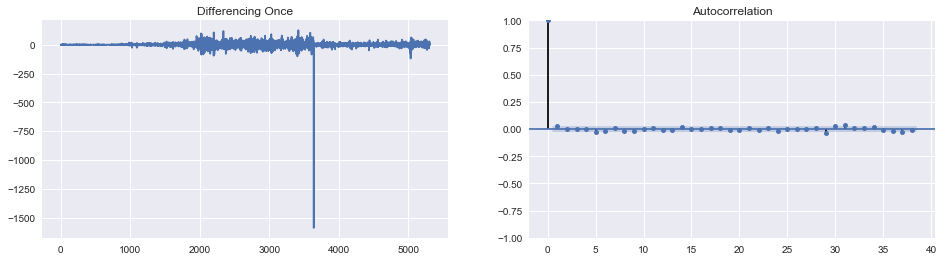

In [16]:
# Creating the Difference Once ACF plot again:

diff2 = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax2.set_ylim(-10, 5)
ax1.plot(diff2)
ax1.set_title("Differencing Once")

plot_acf(diff2, ax=ax2);

Only one value is out of the significance zone so, q parametr is 1

## Fitting the ARIMA Model

In [17]:
import statsmodels.api as sm

In [18]:
model = sm.tsa.arima.ARIMA(df.Close, order=(0,1,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5306
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -25184.216
Date:                Tue, 30 Aug 2022   AIC                          50372.432
Time:                        10:12:06   BIC                          50385.585
Sample:                             0   HQIC                         50377.029
                               - 5306                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0257      0.009      2.775      0.006       0.008       0.044
sigma2       778.5202      0.489   1590.969      0.000     777.561     779.479
Ljung-Box (L1) (Q):                   0.00   Jarque-

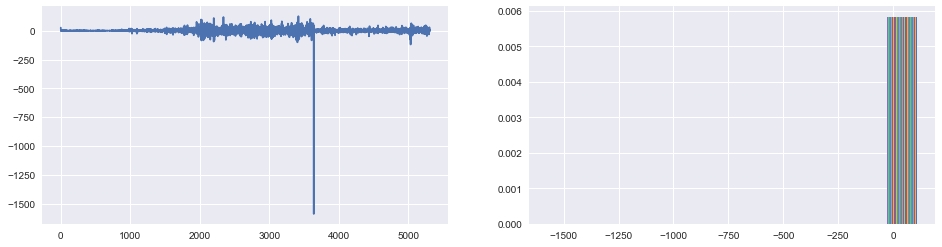

In [19]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

plt.show()

### Cmparing calculated data with the real one

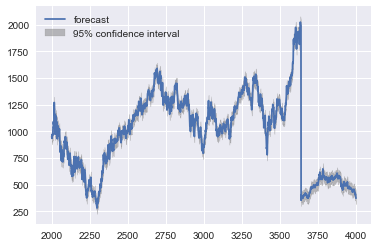

In [20]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(result,
    start = 2000,
    end = 4000,
    dynamic = False,);

## Forecasting

### Train & Test Split

In [21]:
n = int(len(df)*0.8)

train = df.Close[:n]
test = df.Close[n:]

In [22]:
print(len(train))
print(len(test))
#type(train)

4244
1062


#### Fitting the ARIMA Model to the train dataset

In [23]:
model = sm.tsa.arima.ARIMA(train.values, order=(0,1,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4244
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -20519.043
Date:                Tue, 30 Aug 2022   AIC                          41042.085
Time:                        10:13:08   BIC                          41054.791
Sample:                             0   HQIC                         41046.576
                               - 4244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0284      0.010      2.740      0.006       0.008       0.049
sigma2       929.8405      0.696   1335.383      0.000     928.476     931.205
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [24]:
step = 300

fc = result.get_forecast(step)
fc_mean = fc.predicted_mean
fc_conf = fc.conf_int(alpha=0.05)

fc_mean = pd.Series(fc_mean, index=test[:step].index)

lower_conf = pd.Series(fc_conf[:,0], index = test[:step].index)
upper_conf = pd.Series(fc_conf[:,1], index = test[:step].index)

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'Upper left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


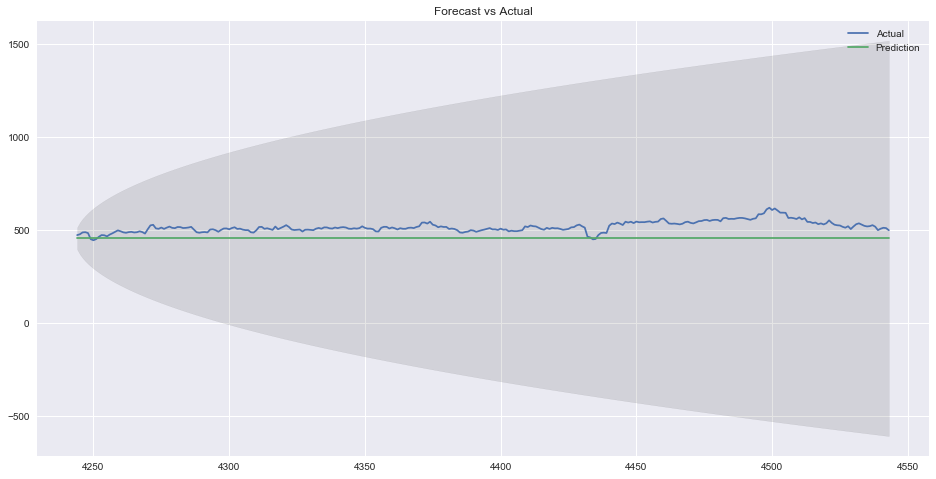

In [25]:
plt.figure(figsize=[16,8])
plt.plot(test[:step], label='Actual')
plt.plot(fc_mean, label='Prediction')
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='k', alpha=0.1)
plt.title('Forecast vs Actual')
plt.legend(loc='Upper left')

#### ARIMA as can be seen from above is not good at forecasting since it requires a stationary series and also assumes/requires linear regressive behavior. Both of these are not true in case of real world data. 
#### Hence we should focus on some other multivariate time series analysis method


### Calculating the Root mean square value

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(fc_mean, test[:step]))
print(rmse)

69.23559845142206


In [28]:
test_mean = test[:step].mean()
print(test_mean)

518.1688333333333


In [30]:
SI = rmse/test_mean*100
print(SI)

13.361590662648643


## Scatter Index (SI) is around 10% so the model is well fitted